In [61]:

from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)

from ophyd.sim import motor1,motor2, noisy_det, det1




Transient Scan ID: 1     Time: 2022-10-24 11:34:20
Persistent Unique Scan ID: 'e09be8a8-e80a-4118-aa2f-740406025b49'
New stream: 'primary'
+-----------+------------+------------+------------+------------+
|   seq_num |       time |     motor1 |       det1 |  noisy_det |
+-----------+------------+------------+------------+------------+
|         1 | 11:34:20.6 |     -1.000 |      0.677 |      0.910 |
|         2 | 11:34:20.7 |     -0.778 |      1.491 |      0.999 |
|         3 | 11:34:20.8 |     -0.556 |      2.697 |      0.928 |
|         4 | 11:34:21.0 |     -0.333 |      4.004 |      0.997 |
|         5 | 11:34:21.1 |     -0.111 |      4.878 |      1.018 |
|         6 | 11:34:21.2 |      0.111 |      4.878 |      1.065 |
|         7 | 11:34:21.3 |      0.333 |      4.004 |      1.031 |
|         8 | 11:34:21.4 |      0.556 |      2.697 |      0.950 |
|         9 | 11:34:21.5 |      0.778 |      1.491 |      1.070 |
|        10 | 11:34:21.7 |      1.000 |      0.677 |      0.933 |
+

('e09be8a8-e80a-4118-aa2f-740406025b49',)

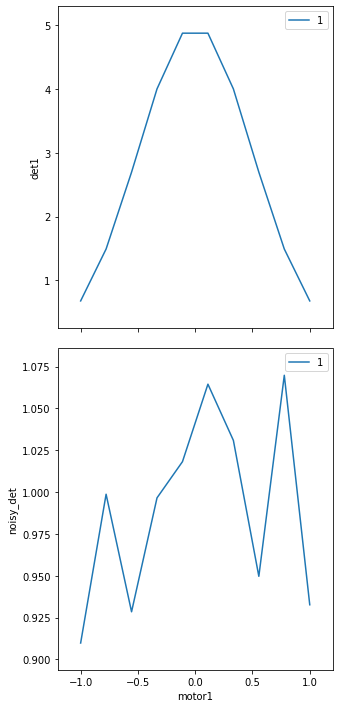

In [62]:
from bluesky.plans import scan

plan = scan([noisy_det,det1],motor1,-1,1,10)

RE(plan)

In [63]:
run=db[-1]

In [64]:
run.primary.read()

<xarray.Dataset>
Dimensions:          (time: 10)
Coordinates:
  * time             (time) float64 1.667e+09 1.667e+09 ... 1.667e+09 1.667e+09
Data variables:
    motor1           (time) float64 -1.0 -0.7778 -0.5556 ... 0.5556 0.7778 1.0
    motor1_setpoint  (time) float64 -1.0 -0.7778 -0.5556 ... 0.5556 0.7778 1.0
    det1             (time) float64 0.6767 1.491 2.697 ... 2.697 1.491 0.6767
    noisy_det        (time) float64 0.9098 0.9987 0.9284 ... 0.9496 1.07 0.9326

In [28]:
from ophyd import Device, EpicsSignal, EpicsSignalRO, PVPositioner, Component as Cpt
from ophyd.device import DynamicDeviceComponent as DDC
import epics
import numpy as np

def BPMnames(**kwargs):
    BPMnames = {}
    #self.BPMrdXPVs = []
    #self.BPMrdYPVs = []

    for arc in range(1,9):
        for dt in ['D','T']:
            for bpm in range(1,8):
                bpmname = 'BPMZ{}{}{}R'.format(str(bpm),dt,str(arc))
                test_connection = epics.PV(bpmname+':rdX')
                if test_connection.status != None:
                    BPMnames[bpmname] = (BPM,bpmname + ':',kwargs)
                    
    
    return BPMnames

class BPM(Device):
    #Readback PVs
    rdX = Cpt(EpicsSignalRO, 'rdX', kind = 'hinted') #horizontal position
    rdY = Cpt(EpicsSignalRO, 'rdY', kind = 'hinted') #vertical position
    
    #Figure out how to return numpy array of [rdX,rdY]??
    
class AllBPMs(Device):
    
    bpms = DDC(BPMnames(kind = 'hinted'),kind = 'normal')
    
    
    
    
    
    '''
    def __init__(self):
        
        self.BPMnames = []
        self.BPMrdXPVs = []
        self.BPMrdYPVs = []
        
        for arc in range(1,9):
            for dt in ['D','T']:
                for bpm in range(1,8):
                    bpmname = 'BPMZ{}{}{}R'.format(str(bpm),dt,str(arc))
                    self.BPMnames.append(bpmname)'''
    
    

In [27]:
from ophyd import Device, EpicsSignal, EpicsSignalRO, PVPositioner, Component as Cpt
import numpy as np

#UE49IT4R:BaseParGapsel.B

class UndulatorGap(PVPositioner):
    #Staging PVs
    
    
    #Setting PVs
    setpoint = Cpt(EpicsSignal,'BaseParGapsel.B', kind = 'normal')
    
    #Readback PVs
    #done = Cpt(EpicsSignalRO, 'BaseStatISLbl', kind = 'omitted', string = True)
    done = Cpt(EpicsSignalRO, 'BaseStatISLbl', kind = 'omitted')
    done_value = 1
    readback = Cpt(EpicsSignalRO, 'CIOC:rdbk0', kind = 'hinted')
    
    #Status/Staging PVs
    action_status = Cpt(EpicsSignal, 'BaseCmdMcmd', string = True, kind = 'config')
    
    #Effecting PVs
    actuate = Cpt(EpicsSignal, 'BaseCmdCalc.PROC', kind = 'omitted')
    
    
    #methods
    def stage (self):
        self.actuate.set(5) #gap drive mode 'START'
        super().stage()
        
class UndulatorShiftParallel(PVPositioner):
    #Staging PVs
    
    
    #Setting PVs
    setpoint = Cpt(EpicsSignal,'SBaseParGapsel.B', kind = 'normal')
    
    #Readback PVs
    #done = Cpt(EpicsSignalRO, 'BaseStatISLbl', kind = 'omitted', string = True)
    done = Cpt(EpicsSignalRO, 'SBaseStatISLbl', kind = 'omitted')
    done_value = 1
    readback = Cpt(EpicsSignalRO, 'CIOC:rdbk2', kind = 'hinted') #parallel Shift Readback
    
    #Status/Staging PVs
    action_status = Cpt(EpicsSignal, 'SBaseCmdMcmd', string = True, kind = 'config')
    
    #Effecting PVs
    actuate = Cpt(EpicsSignal, 'SBaseCmdCalc.PROC', kind = 'omitted')
    
    
    #methods
    def stage (self):
        self.actuate.set(5) #gap drive mode 'START'
        super().stage()
        
class Undulator(Device):
    gap = Cpt(UndulatorGap,'')
    
class UndulatorElliptical(Undulator):
    shift = Cpt(UndulatorShiftParallel,'')
    
    
#UE49 = ue('UE49IT4R:',name = 'UE49')
#U125_2 = u('U125ID2R:',name = 'U125_2')

#dictionary of all undulators
allIDs = {
    'U125_2':Undulator('U125ID2R:', name = 'U125_2'),
    'U49_2':Undulator('U49ID3R:', name = 'U49_2'),
    'U41':Undulator('U41IT3R:', name = 'U41'),
    'U49_1':Undulator('U49ID4R:', name = 'U49_1'),
    'UE49':UndulatorElliptical('UE49IT4R:', name = 'UE49'),
    'UE52':UndulatorElliptical('UE52ID5R:', name = 'UE52'),
    'UE46':UndulatorElliptical('UE46IT5R:', name = 'UE46'),
    'U139':Undulator('U139ID6R:', name = 'U139'),
    'UE56_1':UndulatorElliptical('UE56ID6R:', name = 'UE56_1'),
    'U17':Undulator('U17IT6R:', name = 'U17'),
    'UE48':UndulatorElliptical('UE48IT6R:', name = 'UE48'),
    'UE112':UndulatorElliptical('UE112ID7R:', name = 'UE112'),
    'UE56_2':UndulatorElliptical('UE56ID8R:', name = 'UE56_2'),
             }


In [29]:
ringbpms = AllBPMs(name = 'SR')

In [30]:
allIDs['UE49']

UndulatorElliptical(prefix='UE49IT4R:', name='UE49', read_attrs=['gap', 'gap.setpoint', 'gap.readback', 'shift', 'shift.setpoint', 'shift.readback'], configuration_attrs=['gap', 'gap.action_status', 'shift', 'shift.action_status'])

In [38]:
ringbpms.bpms.BPMZ1D1R.rdX

EpicsSignalRO(read_pv='BPMZ1D1R:rdX', name='SR_bpms_BPMZ1D1R_rdX', parent='SR_bpms_BPMZ1D1R', value=0.007232667499999998, timestamp=1666602581.246427, auto_monitor=False, string=False)



Transient Scan ID: 4     Time: 2022-10-24 11:17:50
Persistent Unique Scan ID: 'facabdbf-fe61-415c-9ace-0a006aac76e1'
New stream: 'primary'
+-----------+------------+----------------------+----------------------+----------------------+----------------------+
|   seq_num |       time | SR_bpms_BPMZ3T7R_rdX | SR_bpms_BPMZ3T7R_rdY | SR_bpms_BPMZ2T7R_rdX | SR_bpms_BPMZ2T7R_rdY |
+-----------+------------+----------------------+----------------------+----------------------+----------------------+
|         1 | 11:17:50.5 |            -0.414337 |             0.647614 |             0.426178 |            -0.384308 |
|         2 | 11:17:50.9 |            -0.414337 |             0.647614 |             0.426178 |            -0.384308 |
|         3 | 11:17:51.4 |            -0.418915 |             0.648834 |             0.433807 |            -0.380646 |
|         4 | 11:17:51.8 |            -0.418915 |             0.648834 |             0.433807 |            -0.380646 |
|         5 | 11:17:52.3 |

('facabdbf-fe61-415c-9ace-0a006aac76e1',)

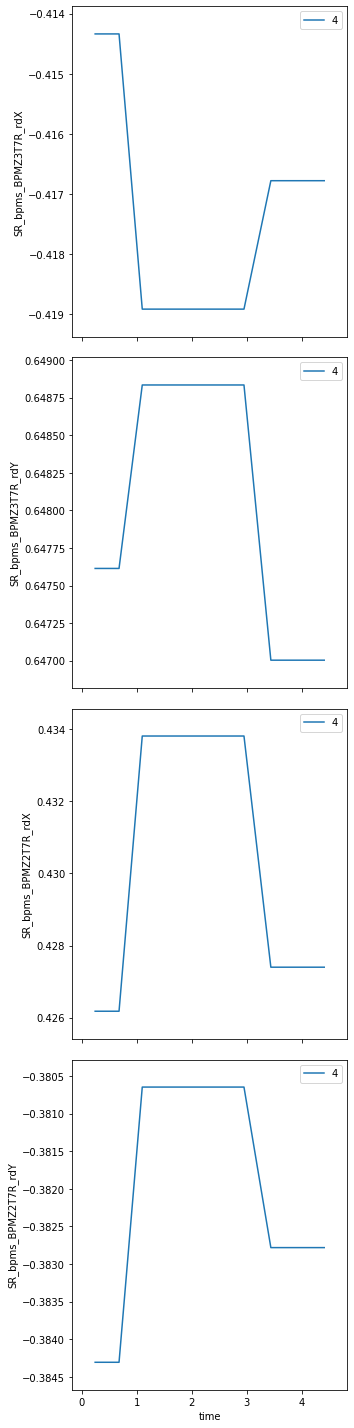

In [42]:
from bluesky.plans import count

RE(count([ringbpms.bpms.BPMZ2T7R, ringbpms.bpms.BPMZ3T7R], 10))


In [48]:
ue48 = allIDs["UE48"]

In [49]:
ue48.gap.setpoint.write_access

True

In [52]:
ue48.gap.move(93)

MoveStatus(done=True, pos=UE48_gap, elapsed=2.3, success=True, settle_time=0.0)

In [53]:
scan??

Signature: scan(detectors, *args, num=None, per_step=None, md=None)
Source:   
def scan(detectors, *args, num=None, per_step=None, md=None):
    """
    Scan over one multi-motor trajectory.

    Parameters
    ----------
    detectors : list
        list of 'readable' objects
    *args :
        For one dimension, ``motor, start, stop``.
        In general:

        .. code-block:: python

            motor1, start1, stop1,
            motor2, start2, start2,
            ...,
            motorN, startN, stopN

        Motors can be any 'settable' object (motor, temp controller, etc.)
    num : integer
        number of points
    per_step : callable, optional
        hook for customizing action of inner loop (messages per step).
        See docstring of :func:`bluesky.plan_stubs.one_nd_step` (the default)
        for details.
    md : dict, optional
        metadata

    See Also
    --------
    :func:`bluesky.plans.relative_inner_product_scan`
    :func:`bluesky.plans.grid_scan`
   



Transient Scan ID: 2     Time: 2022-10-24 11:34:49
Persistent Unique Scan ID: '34bef208-1625-4699-92d8-603e771dbdda'
New stream: 'primary'
+-----------+------------+-------------------+----------------------+----------------------+
|   seq_num |       time | UE48_gap_readback | SR_bpms_BPMZ1T6R_rdX | SR_bpms_BPMZ1T6R_rdY |
+-----------+------------+-------------------+----------------------+----------------------+
|         1 | 11:34:54.5 |             92.00 |            -0.112000 |             0.139618 |
|         2 | 11:34:55.3 |             92.20 |            -0.110779 |             0.136871 |
|         3 | 11:34:56.1 |             92.40 |            -0.110779 |             0.136871 |
|         4 | 11:34:56.9 |             92.60 |            -0.110779 |             0.136871 |
|         5 | 11:34:57.7 |             92.80 |            -0.107422 |             0.139618 |
|         6 | 11:34:58.5 |             93.00 |            -0.107422 |             0.139618 |
|         7 | 11:34:59

('34bef208-1625-4699-92d8-603e771dbdda',)

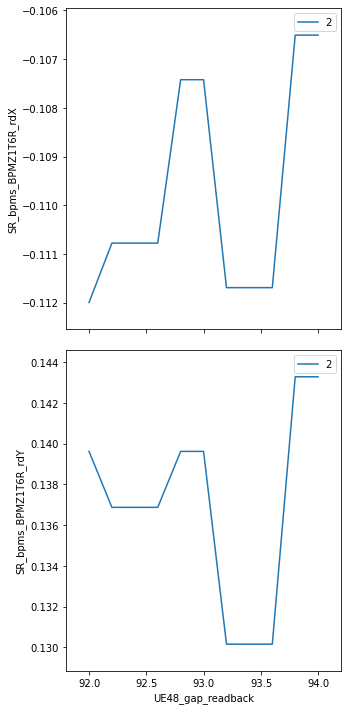

In [65]:
#plan = scan([noisy_det,det1],motor1,-1,1,10)

RE(scan([ringbpms.bpms.BPMZ1T6R],ue48.gap,92,94,11),reason="demo of scan", operator="Ed")

In [66]:
run = db[-1]

In [68]:
run.primary.read()

<xarray.Dataset>
Dimensions:               (time: 11)
Coordinates:
  * time                  (time) float64 1.667e+09 1.667e+09 ... 1.667e+09
Data variables:
    SR_bpms_BPMZ1T6R_rdX  (time) float64 -0.112 -0.1108 ... -0.1065 -0.1065
    SR_bpms_BPMZ1T6R_rdY  (time) float64 0.1396 0.1369 0.1369 ... 0.1433 0.1433
    UE48_gap_setpoint     (time) float64 92.0 92.2 92.4 92.6 ... 93.6 93.8 94.0
    UE48_gap_readback     (time) float64 92.0 92.2 92.4 92.6 ... 93.6 93.8 94.0